<a href="https://colab.research.google.com/github/Translucent504/Playground/blob/master/CMU_FrameClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/Colab Notebooks/CMUDL F19/Recitations/Recitation 4/GoodCodeStructureExample/code

# **Playing**

In [0]:
import paths
import numpy as np
import data
import ffnnmodel
import torch

test = data.get_loader("test")
model = ffnnmodel.FFNN.load()


def get_predictions(model, loader):
    final_result = []
    model.eval()
    model.to(torch.device("cuda"))
    for x in loader:
        x = x.to(torch.device("cuda"))
        output = model(x)
        result = np.argmax(output.cpu().detach().numpy(), axis=1)
        final_result.append(result)
    return np.concatenate(final_result)

results = get_predictions(model, test)

In [0]:
tmp = list(zip(range(len(results)), results))
import csv
with open('150x4val206.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['id','label'])
    writer.writerows(tmp)

In [0]:
import data
import ffnnmodel
import routine
import config
import numpy as np

# To run, make sure you have a data/ folder containing MNIST and a model/ folder along with your code/ folder

def run():
    train_loader = data.get_loader("train")
    val_loader = data.get_loader("val")
    test_loader = data.get_loader("test")
    #test_labels = data.get_test_labels()

    if config.load_model:
        model = ffnnmodel.FFNN.load()
    else:
        model = ffnnmodel.FFNN()

    routine.train(model, train_loader, val_loader)
    test_outputs = routine.predict(model, test_loader)
    print((test_outputs))
    try:
    	np.savetxt('prediction.csv', test_outputs, delimiter=",")
    except:
        print("prediction not saved")
    #accuracy = (test_outputs == test_labels).mean()
    #print("Test accuracy :", accuracy)

if __name__ == "__main__":
    run()


# **From Scratch**

## **Setup Google Drive**

In [0]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/Colab Notebooks/CMUDL F19/Recitations/Recitation 4/GoodCodeStructureExample/code

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks/CMUDL F19/Recitations/Recitation 4/GoodCodeStructureExample/code


## **Imports**

In [0]:
%matplotlib inline
import time
import torch
import torch.nn as nn
import numpy as np
import csv
import math
import matplotlib
import matplotlib.pyplot as plt

from tqdm import tqdm
from pathlib import Path
from torch.utils.data import TensorDataset, DataLoader, Dataset

## **Data Loading Cells**

### WSJ Dataset

In [0]:
class WSJDataset(Dataset):
    """
    Expects data in the form of an array of recordings
    each recording has N utterances or elements
    each element is a 10ms frame represented by a 40 sized frequency/energy vector.
    each element can then be interpretted as a phoneme.
    """
    def __init__(self, X, Y=None):
        self.Y = Y 
        if self.Y is not None:
          tmp_Y = np.concatenate(tuple(Y[:]), axis=0)
          self.Y = torch.from_numpy(tmp_Y).long()
        self.context = CONTEXT
        tmp_X = np.concatenate(tuple(X[:]), axis=0)
        tmp_X = np.pad(tmp_X,((self.context, self.context),(0,0)), mode='reflect')
        self.X = torch.from_numpy(tmp_X).float()
        
    def __len__(self):
      if self.Y is not None:
        return len(self.Y)
      else:
        return self.X.shape[0] - 2*self.context

    def __getitem__(self,index):
        X = self.X[index:index + 2*self.context+1].reshape(-1)  #flatten the input
        if self.Y is not None:
          Y = self.Y[index]
          return X, Y
        else:
          return X

In [0]:
def get_loader(mode="train"):
    if mode == "train":
        data_path = TRAIN_DPATH
        labels_path = TRAIN_LPATH
        shuffle = True
    if mode == "val":
        data_path = VALID_DPATH
        labels_path = VALID_LPATH
        shuffle = False
    if mode == "test":
        data_path = TEST_DPATH
        labels_path = None
        shuffle = False
    data = np.load(data_path, allow_pickle=True)

    if SANITY:
        data = data[:SANITYSIZE]

    if labels_path:
        labels = np.load(labels_path, allow_pickle=True)
        if SANITY:
            labels = labels[:SANITYSIZE]
        dataset = WSJDataset(data, labels)                                
    else:
        dataset = WSJDataset(data)
    print(f"{mode} Dataset Size: {len(dataset)}")
    dataloader = DataLoader(dataset, shuffle=shuffle, batch_size=BATCH_SIZE, drop_last=False)

    return dataloader

## Routine :

In [0]:
def run_one_epoch(model, loader, criterion, update=True, optimizer=None, scheduler=None):
    cum_loss = 0
    plotloss = []
    lrs = []
    i = 0
    corr_preds = 0
    for x, y in tqdm(loader):
        x = x.to(device)
        y = y.to(device)
        output = model(x)
        loss = criterion(output, y)
        if update:
            lrplot = scheduler.get_lr()
            lrs.append(lrplot)
            if i % 1000 == 0:
                print(f"Learning rate: {lrplot}")
            loss.backward()
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
        plotloss.append(loss.cpu().detach().numpy().item()) 
        # Per batch Accuracy data:
        out = np.argmax(output.cpu().detach().numpy(), axis=1)
        true = y.cpu().detach().numpy()
        if WSJ and i % 1000 == 0:
            print(f"Current Batch Accuracy: {(np.sum(true==out)/len(true))*100}%")
        corr_preds += np.sum(true==out)
        i+=1   
        cum_loss += loss.cpu().detach().numpy().item()
    # Overall per Epoch Accuracy
    if update:
        print(f"Training Epoch Accuracy: {100*corr_preds/len(loader.dataset)}%")
        plt.plot(lrs, plotloss)
        plt.xscale("log")
        plt.show()
    else:
        print(f"Validation Epoch Accuracy: {100*corr_preds/len(loader.dataset)}%")
        plt.plot(plotloss)
        plt.show()
    return cum_loss/len(loader)

In [0]:
def lr_find(model, loader, optimizer, min_lr=1e-7, max_lr=1.0):
    cum_loss = 0
    plotloss = []
    lrs = []
    i = 0
    n = math.log(number, 1.01)
    corr_preds = 0
    for x, y in tqdm(loader):
        x = x.to(device)
        y = y.to(device)
        output = model(x)
        loss = criterion(output, y)
        lrs.append(lrplot)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        lr = optimizer.param_groups[0]['lr']
        optimizer.param_groups[0]['lr'] = lr * 1.1
        plotloss.append(loss.cpu().detach().numpy().item()) 
        i+=1   
        cum_loss += loss.cpu().detach().numpy().item()

    print(f"Training Epoch Accuracy: {100*corr_preds/len(loader.dataset)}%")
    plt.plot(lrs, plotloss)
    plt.xscale("log")
    plt.show()
    return cum_loss/len(loader)



In [0]:
def train(model, train_dataloader, val_dataloader):
    max_epoch = MAX_EPOCHS
    lr = LEARNING_RATE
    if SANITY:
        max_epoch = SANITYEPOCH
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=0.0001)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,max_lr=SCH_RATE,steps_per_epoch=len(train_dataloader), epochs=max_epoch)
    model = model.to(device)
    val_losses = []
    train_losses = []
    best_loss = 10000
    print('Begin training')
    for epoch in range(max_epoch):
        start = time.time()
        print("Epoch: ", epoch+1)
        #print("Learning Rate: ", lr)
        model.train()
        train_loss = run_one_epoch(model, train_dataloader, criterion, True, optimizer, scheduler)
        train_losses.append(train_loss)
        print("Training loss: ", train_loss)
        model.eval()
        val_loss = run_one_epoch(model, val_dataloader, criterion, False)
        val_losses.append(val_loss)
        print("Validation loss: ", val_loss)
        stop = time.time()
        if val_loss < best_loss:
            best_loss = val_loss
            print("Saving Model....")
            model.save()
        
        print(f"Time :{stop-start}s")
    return val_losses, train_losses
    


def get_predictions(model, loader):
    final_result = []
    model.eval()
    model.to(torch.device("cuda"))
    for x in loader:
        x = x.to(torch.device("cuda"))
        output = model(x)
        result = np.argmax(output.cpu().detach().numpy(), axis=1)
        final_result.append(result)
    return np.concatenate(final_result)

## Model

In [0]:
class FFNN(nn.Sequential):

    def __init__(self):
        l = []
        sizes = [INPUT_SIZE] + HIDDEN_SIZE + [NUM_CLASSES]
        for i in range(len(sizes)-2):
            l.append(nn.Linear(sizes[i], sizes[i+1]))
            l.append(nn.BatchNorm1d(sizes[i+1]))
            l.append(nn.ReLU())
        l.append(nn.Linear(sizes[-2], sizes[-1]))
        super(FFNN, self).__init__(*l)

    @staticmethod
    def load():
        model = FFNN()
        path = MODEL_PATH
        model.load_state_dict(torch.load(path))

        return model

    def save(self):
        path = MODEL_PATH
        torch.save(self.state_dict(), path)

## **Config Cell**

(𝐿𝑅 ∗ 𝑊𝐷)/(𝑇𝐵𝑆 ∗ (1 − α)) ≈ 𝑐𝑜𝑛𝑠𝑡𝑎𝑛𝑡

α - momentum

In [0]:
# Data Parameters
data_folder = Path("../float16/")
mnist_data_folder = Path("../data/")
WSJ = True
if WSJ:
  TRAIN_DPATH = data_folder/'train.npy' 
  TRAIN_LPATH = data_folder/'train_labels.npy'
  VALID_DPATH = data_folder/'dev.npy'
  VALID_LPATH = data_folder/'dev_labels.npy'
  TEST_DPATH = data_folder/'test.npy'
  MODEL_PATH = Path("../model/tqdm.pt")
  # Model Parameters
  torch.manual_seed(0)
  np.random.seed(0)
  LOAD_MODEL = False
  MAX_EPOCHS = 1
  BATCH_SIZE = 1024
  LEARNING_RATE = 1e-5
  SCH_RATE = 5e-3
  MOMENTUM = 0.9
  CONTEXT = 15
  INPUT_SIZE = 40 * (2*CONTEXT + 1)
  HIDDEN_SIZE = [1240]*6
  NUM_CLASSES = 138
else:
  TRAIN_DPATH = mnist_data_folder/'train.npy' 
  TRAIN_LPATH = mnist_data_folder/'train_labels.npy'
  VALID_DPATH = mnist_data_folder/'dev.npy'
  VALID_LPATH = mnist_data_folder/'dev_labels.npy'
  TEST_DPATH = mnist_data_folder/'test.npy'
  MODEL_PATH = Path("../model/MNISTMODEL.pt")
  # Model Parameters
  torch.manual_seed(0)
  np.random.seed(0)
  LOAD_MODEL = False
  MAX_EPOCHS = 10
  BATCH_SIZE = 64
  LEARNING_RATE = 1e-6
  SCH_RATE = 1e-5
  MOMENTUM = 0.9
  INPUT_SIZE = 784
  HIDDEN_SIZE = [512,512,512,512,512,512,512,512]
  NUM_CLASSES = 10

# Sanity / Training
SANITY = False
SANITYSIZE = 1100
SANITYEPOCH = 2
cuda = True
device = "cuda" if cuda else "cpu"

## Runtime

In [0]:
def run():
    train_loader = get_loader("train")
    val_loader = get_loader("val")

    if LOAD_MODEL:
        model = FFNN.load()
    else:
        model = FFNN()

    val_losses, train_losses = train(model, train_loader, val_loader)
    plt.plot(val_losses)
    plt.plot(train_losses)
    plt.title("Validation Loss");
    plt.xlabel("Iterations");
    plt.ylabel("Loss");
    return (val_losses, train_losses)

train Dataset Size: 15388713


  0%|          | 0/15029 [00:00<?, ?it/s]

val Dataset Size: 675836
Begin training
Epoch:  1


  0%|          | 1/15029 [00:01<7:45:47,  1.86s/it]

Learning rate: [0.00019999999999999966]
Current Batch Accuracy: 0.48828125%


  7%|▋         | 1003/15029 [01:04<17:51, 13.09it/s]

Learning rate: [0.0007596549238958116]
Current Batch Accuracy: 32.8125%


 13%|█▎        | 2003/15029 [02:07<13:18, 16.31it/s]

Learning rate: [0.002177608334049224]
Current Batch Accuracy: 36.328125%


 20%|█▉        | 3003/15029 [03:10<11:40, 17.17it/s]

Learning rate: [0.0037925563905875587]
Current Batch Accuracy: 40.72265625%


 27%|██▋       | 4001/15029 [04:12<10:15, 17.91it/s]

Learning rate: [0.004851321067112773]
Current Batch Accuracy: 35.44921875%


 33%|███▎      | 5003/15029 [05:14<09:53, 16.89it/s]

Learning rate: [0.0049730332180343674]
Current Batch Accuracy: 41.796875%


 40%|███▉      | 6003/15029 [06:14<08:19, 18.06it/s]

Learning rate: [0.004755845387529389]
Current Batch Accuracy: 42.08984375%


 47%|████▋     | 7003/15029 [07:14<07:26, 17.99it/s]

Learning rate: [0.004338983727986821]
Current Batch Accuracy: 42.67578125%


 53%|█████▎    | 8003/15029 [08:14<07:28, 15.68it/s]

Learning rate: [0.003759346483046238]
Current Batch Accuracy: 41.50390625%


 60%|█████▉    | 9003/15029 [09:14<05:39, 17.74it/s]

Learning rate: [0.0030682398733609304]
Current Batch Accuracy: 46.6796875%


 67%|██████▋   | 10003/15029 [10:14<04:35, 18.27it/s]

Learning rate: [0.002326836759234407]
Current Batch Accuracy: 47.8515625%


 73%|███████▎  | 11003/15029 [11:14<04:33, 14.71it/s]

Learning rate: [0.0016007619639478443]
Current Batch Accuracy: 47.0703125%


 80%|███████▉  | 12003/15029 [12:14<02:49, 17.87it/s]

Learning rate: [0.0009542835344270105]
Current Batch Accuracy: 47.16796875%


 87%|████████▋ | 13003/15029 [13:14<01:50, 18.38it/s]

Learning rate: [0.00044462409610203905]
Current Batch Accuracy: 51.5625%


 93%|█████████▎| 14001/15029 [14:13<00:55, 18.58it/s]

Learning rate: [0.0001168958287525649]
Current Batch Accuracy: 50.09765625%


100%|█████████▉| 15003/15029 [15:13<00:01, 17.04it/s]

Learning rate: [1.0739071743812784e-07]
Current Batch Accuracy: 51.171875%


100%|██████████| 15029/15029 [15:15<00:00, 11.16it/s]


Training Epoch Accuracy: 43.28398352740739%


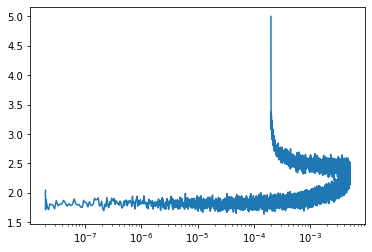

  0%|          | 0/660 [00:00<?, ?it/s]

Training loss:  2.171063547196586


AttributeError: ignored

In [0]:
v,t=run();

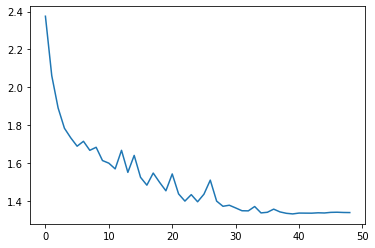

In [0]:
tempo = np.array([2.3753485043843585,2.0615390134580207,1.8913816471894582,1.7839566740122708,
         1.7331338983593565,1.6891762694626145,1.7151012378208566,1.6674280624498021,
         1.6835154702266057,1.6134144763151805,1.5996342856775632,1.5694274478789532,
         1.6674274412971555,1.5510204764026585,1.6405746139360198,1.5249536400491541,
         1.4834835471528949,1.5473498891700397,1.4986431845209816,1.4536923199892045,
         1.542754511851253,1.4373818435452201,1.3993541067296809,1.433429891051668,
         1.3958047336701191,1.4357629985520335,1.5100324656927224,1.399349873625871,
         1.3719498879981764,1.3774904342311802,1.3632555172298895,1.3484137666044813,
         1.3477942674448995,1.3707056564815117,1.3369793112530852,1.3402825184843756,
         1.356912567579385,1.3421990789247282,1.334889861038237,1.3316648706342236,
         1.336125900889888,1.335822554339062,1.3355693424289876,1.337578166163329,
         1.336651961460258,1.3398560769630201,1.3405852402701521,1.3392708445137198,1.3387861782854253])
plt.plot(tempo)

## Hyperparam stuff

In [0]:
# lr_finder
lr_list = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
ttrain_loader = get_loader("train")
vval_loader = get_loader("val")
val_losses = []
train_losses = []
FRESH = True
SANITY = True
SANITYSIZE = 1100
SANITYEPOCH = 10
if FRESH:
    mmodel = FFNN()
    mmodel.save()
for lr in lr_list:
    LEARNING_RATE=lr
    val, trains = train(mmodel, ttrain_loader, vval_loader)
    val_losses.extend(val)
    train_losses.extend(trains)
plt.plot(val_losses)
plt.plot(train_losses)
plt.xlabel("Learning rate")
plt.ylabel("Loss")
#plt.xticks(range(0,SANITYEPOCH*len(lr_list),10), map(str, lr_list))
        



train Dataset Size: 667411
val Dataset Size: 675836
Begin training
Epoch:  1
Learning Rate:  1e-07
Training loss:  4.924452876934976
Validation loss:  4.924017782644792
Saving Model....
Time :36.21047854423523s
Epoch:  2
Learning Rate:  1e-07


KeyboardInterrupt: ignored

## Prediction

In [0]:
model = FFNN.load()
test = get_loader("test")
results = get_predictions(model, test)
tmp = list(zip(range(len(results)), results))
with open('predt680v639.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['id','label'])
    writer.writerows(tmp)

test Dataset Size: 223592


# Testing MNIST



In [0]:
mnist_train = np.load("../data/train.npy")
mnist_train_labels = np.load("../data/train_labels.npy")
mnist_dev = np.load("../data/dev.npy")
mnist_dev_labels = np.load("../data/dev_labels.npy")


(50000, 784) (50000,) (10000, 784) (10000,)
Begin training
Epoch:  1
Learning rate: [3.9999999999999956e-07]
Training Epoch Accuracy: 27.014%
Training loss:  2.209235254760898
Validation Epoch Accuracy: 64.78%
Validation loss:  1.6154187560840776
Saving Model....
Time :3.879451274871826s
Epoch:  2
Learning rate: [2.801856579744565e-06]
Training Epoch Accuracy: 84.382%
Training loss:  0.5975573842539964
Validation Epoch Accuracy: 91.45%
Validation loss:  0.2898275336357439
Saving Model....
Time :3.834383726119995s
Epoch:  3
Learning rate: [7.6037117232856525e-06]
Training Epoch Accuracy: 92.376%
Training loss:  0.26428379548137143
Validation Epoch Accuracy: 93.82%
Validation loss:  0.21017339728345538
Saving Model....
Time :3.778704881668091s
Epoch:  4
Learning rate: [9.999999176566715e-06]
Training Epoch Accuracy: 94.254%
Training loss:  0.19390377388966967
Validation Epoch Accuracy: 95.51%
Validation loss:  0.1572481741903314
Saving Model....
Time :3.807025194168091s
Epoch:  5
Learnin

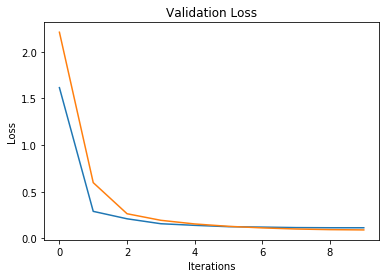

In [0]:
print(mnist_train.shape,mnist_train_labels.shape, mnist_dev.shape,mnist_dev_labels.shape)

class MNIST_dataset(Dataset):
  def __init__(self, X, Y):
    self.X = torch.from_numpy(X).float()
    self.Y = torch.from_numpy(Y).long()
  
  def __len__(self):
    return len(self.Y)

  def __getitem__(self, index):
    return self.X[index], self.Y[index]

mnist_train_data = MNIST_dataset(mnist_train, mnist_train_labels)
mnist_dev_data = MNIST_dataset(mnist_dev, mnist_dev_labels)
mnist_train_dataloader = DataLoader(mnist_train_data,batch_size=BATCH_SIZE,shuffle=True)
mnist_dev_dataloader = DataLoader(mnist_dev_data,batch_size=BATCH_SIZE,shuffle=False)

model = FFNN()
val_losses, train_losses = train(model, mnist_train_dataloader, mnist_dev_dataloader)
plt.plot(val_losses)
plt.plot(train_losses)
plt.title("Validation Loss");
plt.xlabel("Iterations");
plt.ylabel("Loss");
